In [1]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from utils.utils_embedding import evaluate_embedding, plot_embeddings, create_set_embeddings, load_qa_dataset, get_embeddings, finetune_or_load_embedding_model
from sklearn.decomposition import PCA
%matplotlib inline
import seaborn as sns; sns.set()
from sentence_transformers import util
from loguru import logger

/opt/homebrew/Caskroom/miniconda/base/envs/agent/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from setting.rag.embedding.pca_vis_config import PCAConfig

pca_params = PCAConfig()
pca_params.top_k

3

In [3]:
it_dataset = load_qa_dataset(pca_params.dataset_name)

2025-07-24 17:51:43.624 | INFO     | utils.utils_embedding:load_qa_dataset:19 - Loading dataset from QA/codice/gpt-35-turbo_temperature_1_dataset.json


In [4]:
embed_model_paraphrase_l12 = HuggingFaceEmbedding(model_name=pca_params.model_name)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [5]:
df_no_finetuned_results_it = evaluate_embedding(dataset=it_dataset, 
                                    embed_model=embed_model_paraphrase_l12, 
                                    top_k=pca_params.top_k,
                                    verbose=True)

print(len(df_no_finetuned_results_it))
df_no_finetuned_results_it.tail(10)

100%|██████████| 703/703 [00:13<00:00, 52.59it/s]

703


,is_hit,mrr,retrieved,expected,query
693,False,0.0,"[3f53a355-2694-4bb4-b0cf-6090677acf9c, 9947db1...",e40638c8-d8d2-47c1-9a32-f93f2e94838a,7bec81d3-c296-4ff5-a87b-94ef2e0b833e
694,True,0.5,"[459e4682-2fa9-4a7a-ab73-1d08976662ee, 54f6dc7...",54f6dc74-9148-4f73-a270-65e9b0f35e97,47ef127d-40ad-4ca7-a364-df6aa4ab5523
695,False,0.0,"[bda4b2bc-2342-4c51-afb2-764cdd4e09b2, 02f7f44...",53255682-cc6e-44a1-93b0-dd8c6b461bca,df4a882b-8f72-4533-8aed-ce33bc3fe366
696,False,0.0,"[02cc81d5-63d5-4853-a77e-37ddf3b6d76e, 4f2de15...",bed1a39d-80d4-43f6-b79a-44b52f99213a,f02264a7-1ae0-457e-9f5d-6b025a85cac5
697,True,1.0,"[1f3e47bd-8025-4655-a339-59414da55e5f, 962f793...",1f3e47bd-8025-4655-a339-59414da55e5f,b8f61efc-4ed9-4d6a-9195-a668f7408dee
698,False,0.0,"[4eec1f73-6848-4143-956b-c7566b6043c3, fdaf04d...",c74a2ec6-87d6-41c7-8275-0ba2279ea018,28c0ef2e-1200-4e70-b15e-875f48d2b949
699,True,1.0,"[4eec1f73-6848-4143-956b-c7566b6043c3, 459e468...",4eec1f73-6848-4143-956b-c7566b6043c3,99ee3397-1106-4b1a-83f0-4b0aef0bbe1c
700,False,0.0,"[75f71e3b-a0dc-4a99-a28e-17402dc021ad, e2b646c...",0bc7a6ab-3e7f-4855-9f55-82b28b8f3cbd,3e88f0fb-f5fb-4be1-9535-7c300a74c87e
701,False,0.0,"[2a409727-757a-401d-9c4a-14429afa41bb, 4ec183e...",75f71e3b-a0dc-4a99-a28e-17402dc021ad,ff851282-3b32-4540-abcc-d7f2445ff0a7
702,True,1.0,"[2a409727-757a-401d-9c4a-14429afa41bb, 962f793...",2a409727-757a-401d-9c4a-14429afa41bb,da10f75d-86ac-4b4a-a60e-82c2837d724e


In [6]:
pca = PCA(n_components=pca_params.num_pca_components)
array_embeddings_paraphrase_l12_it = create_set_embeddings(it_dataset, embed_model_paraphrase_l12)
projected = pca.fit_transform(array_embeddings_paraphrase_l12_it)

100%|██████████| 703/703 [00:10<00:00, 67.41it/s]


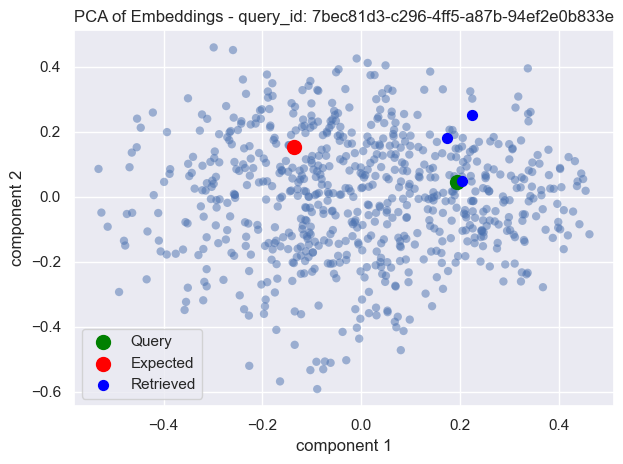

2025-07-24 17:52:37.990 | INFO     | __main__:<module>:11 - Mean cosine similarity between query and retrieved embeddings: 0.7410


In [8]:
query_id = '7bec81d3-c296-4ff5-a87b-94ef2e0b833e'

query_embedding, expected_embedding, list_retrieved_embedding = get_embeddings(query_id=query_id,
                                                                               embedding_model=embed_model_paraphrase_l12,
                                                                               df_results=df_no_finetuned_results_it,
                                                                               qa_dataset=it_dataset)

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_no_finetune_1.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

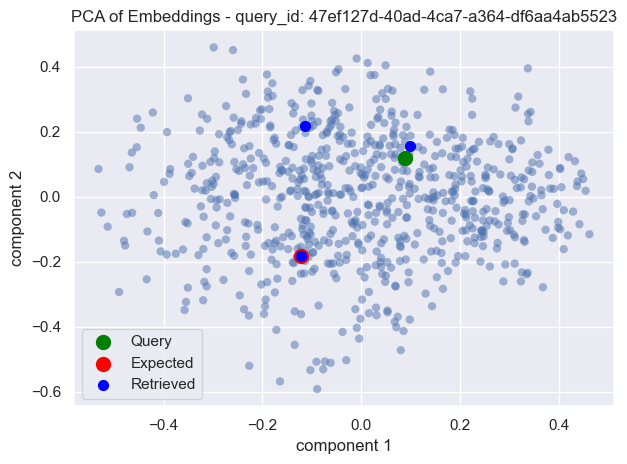

2025-07-24 17:53:01.268 | INFO     | __main__:<module>:11 - Mean cosine similarity between query and retrieved embeddings: 0.7196


In [9]:
query_id = '47ef127d-40ad-4ca7-a364-df6aa4ab5523'

query_embedding, expected_embedding, list_retrieved_embedding = get_embeddings(query_id=query_id,
                                                                               embedding_model=embed_model_paraphrase_l12,
                                                                               df_results=df_no_finetuned_results_it,
                                                                               qa_dataset=it_dataset)

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_no_finetune_2.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

# Load or finetuned embedding model

In [10]:
finetuned_embed_model = finetune_or_load_embedding_model(it_dataset, 
                                                        pca_params.model_name,
                                                        pca_params.finetuned_filename,
                                                        num_epochs=pca_params.num_epochs)
finetuned_embed_model

2025-07-24 17:53:12.358 | INFO     | utils.utils_embedding:finetune_or_load_embedding_model:156 - Loading finetuned model from finetuned-sentence-transformers/codice/finetuned-paraphrase-multilingual-MiniLM-L12-v2_gpt-35-turbo_temperature_1_dataset...


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: finetuned-sentence-transformers/codice/finetuned-paraphrase-multilingual-MiniLM-L12-v2_gpt-35-turbo_temperature_1_dataset
Load pretrained SentenceTransformer: finetuned-sentence-transformers/codice/finetuned-paraphrase-multilingual-MiniLM-L12-v2_gpt-35-turbo_temperature_1_dataset


HuggingFaceEmbedding(model_name='finetuned-sentence-transformers/codice/finetuned-paraphrase-multilingual-MiniLM-L12-v2_gpt-35-turbo_temperature_1_dataset', embed_batch_size=10, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x357bc6d90>, num_workers=None, embeddings_cache=None, max_length=128, normalize=True, query_instruction=None, text_instruction=None, cache_folder=None, show_progress_bar=False)

In [11]:
df_finetuned_results_it = evaluate_embedding(dataset=it_dataset, 
                                             embed_model=finetuned_embed_model, 
                                             top_k=pca_params.top_k, 
                                             verbose=True)
print(len(df_finetuned_results_it))
df_finetuned_results_it.head()

100%|██████████| 703/703 [00:12<00:00, 58.25it/s]

703


,is_hit,mrr,retrieved,expected,query
0,False,0.0,"[cf4077b9-da9a-4354-9aca-131c95c0da62, 8db2fcc...",565c5f5d-9641-4ba1-8a1e-c73c96d83aad,f33b10f0-60a7-4d74-9b65-3cd59c44cf2b
1,False,0.0,"[46cff5de-1164-4a64-a032-b762958c49db, e2c72b0...",4dafe1c0-2fe9-439b-8805-85b21b159660,feaec8e1-ebe1-49b4-bcfc-8f21693634c4
2,True,1.0,"[46cff5de-1164-4a64-a032-b762958c49db, 1e2f274...",46cff5de-1164-4a64-a032-b762958c49db,4538dfdd-9d55-483a-acf7-b47def38ed0f
3,True,1.0,"[5ff1b878-d40d-4bf5-9042-4f6f9bc10295, 7afdc62...",5ff1b878-d40d-4bf5-9042-4f6f9bc10295,6ef165e4-2fb5-46ec-82ac-6613479d22e7
4,True,0.5,"[1aa08d57-a66e-4428-a6c1-ee47e0717196, 14e2713...",14e27137-bfd0-47ee-a4d9-ab255ff998c1,00818e3b-3be9-4c49-9db8-1fde2e135d15


In [12]:
array_embeddings_finetuned = create_set_embeddings(it_dataset, finetuned_embed_model)
projected = pca.fit_transform(array_embeddings_finetuned)

100%|██████████| 703/703 [00:10<00:00, 65.51it/s]


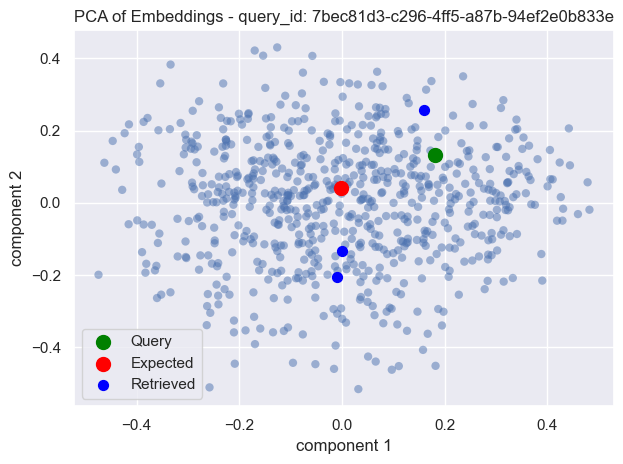

2025-07-24 17:53:54.509 | INFO     | __main__:<module>:11 - Mean cosine similarity between query and retrieved embeddings: 0.6217


In [13]:
query_id = '7bec81d3-c296-4ff5-a87b-94ef2e0b833e'

query_embedding, expected_embedding, list_retrieved_embedding = get_embeddings(query_id=query_id,
                                                                               embedding_model=finetuned_embed_model,
                                                                               df_results=df_finetuned_results_it,
                                                                               qa_dataset=it_dataset)

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_finetune_1.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")

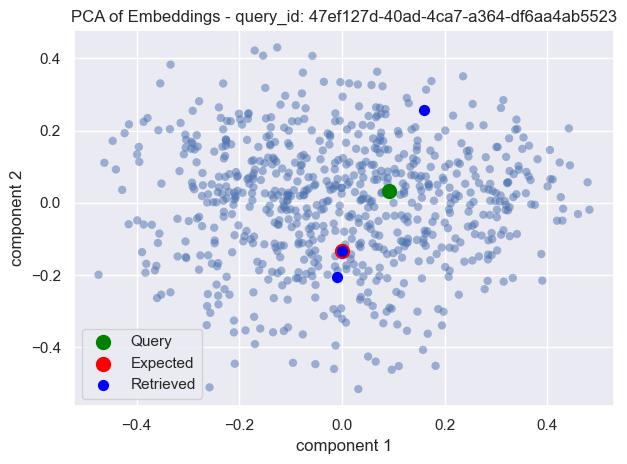

2025-07-24 17:54:18.752 | INFO     | __main__:<module>:11 - Mean cosine similarity between query and retrieved embeddings: 0.5602


In [14]:
query_id = '47ef127d-40ad-4ca7-a364-df6aa4ab5523'

query_embedding, expected_embedding, list_retrieved_embedding = get_embeddings(query_id=query_id,
                                                                               embedding_model=finetuned_embed_model,
                                                                               df_results=df_finetuned_results_it,
                                                                               qa_dataset=it_dataset)

plot_embeddings(pca, query_id, projected, query_embedding, expected_embedding, list_retrieved_embedding, filename="imgs/embeddings_pca_finetune_2.png")

mean_cosine_similarity = util.cos_sim(query_embedding, list_retrieved_embedding).mean().item()
logger.info(f"Mean cosine similarity between query and retrieved embeddings: {mean_cosine_similarity:.4f}")